In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pyparsing import actions
from torch.autograd.graph import saved_tensors_hooks
from torch.distributions import Categorical
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- Define Policy Network ---
# it takes state as input and outputs action probabilities
class PolicyNet(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, n_actions)

    def forward(self, x):
        # return each logits of the action (before softmax)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- Main Training Logic ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LEARNING_RATE = 0.01
GAMMA = 0.99
NUM_EPISODES = 1000

env = gym.make('CartPole-v1')
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_net = PolicyNet(n_observations, n_actions).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

episode_rewards = []

#   --- Training Loop ---
for i_episode in range(NUM_EPISODES):
    # 1. Generate an episode {s0, a0, r1, ..., rT} following pi(theta)
    saved_log_probs = [] # store log(pi(a|s)) for each action taken
    rewards = [] # store rewards for each step

    state, info = env.reset()
    done = False

    while not done:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

        logits = policy_net(state_tensor) # Get action logits from the policy network

        m = Categorical(logits=logits) # Create a categorical distribution from logits
        action = m.sample() # Sample an action from the distribution

        saved_log_probs.append(m.log_prob(action))

        # Take the action in the environment
        state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        rewards.append(reward)

    episode_rewards.append(sum(rewards))

    # 2. For t = 0, 1, ..., T-1:
    #    Compute the return q_t (Value update)
    returns = []
    discounted_returns = 0

    for r in reversed(range(len(rewards))):
        discounted_return = r + GAMMA * discounted_returns
        returns.insert(0, discounted_return)

    returns = torch.tensor(returns, device=device)

    returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # Normalize returns

    policy_loss = []
    for log_prob, R in zip(saved_log_probs, returns):
        policy_loss.append(-log_prob * R)

    loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i_episode + 1) % 50 == 0:
        print(f"Episode {i_episode+1}/{NUM_EPISODES} | "
              f"Total Reward: {sum(rewards):.2f} | "
              f"Avg Reward (Last 50): {np.mean(episode_rewards[-50:]):.2f}")

print("\n--- Training Finished ---")

Episode 50/1000 | Total Reward: 14.00 | Avg Reward (Last 50): 14.88
Episode 100/1000 | Total Reward: 10.00 | Avg Reward (Last 50): 10.04
Episode 150/1000 | Total Reward: 8.00 | Avg Reward (Last 50): 9.56
Episode 200/1000 | Total Reward: 9.00 | Avg Reward (Last 50): 9.40
Episode 250/1000 | Total Reward: 10.00 | Avg Reward (Last 50): 10.66
Episode 300/1000 | Total Reward: 8.00 | Avg Reward (Last 50): 9.78
Episode 350/1000 | Total Reward: 12.00 | Avg Reward (Last 50): 10.06
Episode 400/1000 | Total Reward: 8.00 | Avg Reward (Last 50): 10.36
Episode 450/1000 | Total Reward: 9.00 | Avg Reward (Last 50): 9.70
Episode 500/1000 | Total Reward: 9.00 | Avg Reward (Last 50): 9.44
Episode 550/1000 | Total Reward: 10.00 | Avg Reward (Last 50): 9.24
Episode 600/1000 | Total Reward: 10.00 | Avg Reward (Last 50): 9.36
Episode 650/1000 | Total Reward: 9.00 | Avg Reward (Last 50): 9.46
Episode 700/1000 | Total Reward: 12.00 | Avg Reward (Last 50): 9.62
Episode 750/1000 | Total Reward: 10.00 | Avg Reward

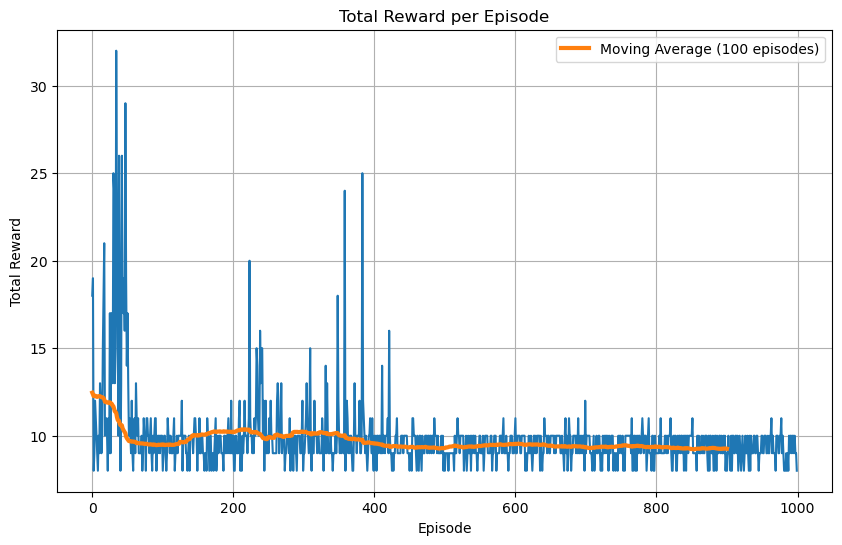

In [3]:
# --- Plotting Results ---
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

moving_avg = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')
plt.plot(moving_avg, label='Moving Average (100 episodes)', linewidth=3)
plt.legend()
plt.grid(True)
plt.show()

In [4]:
print("\n--- 渲染学到的最终策略 ---")
env = gym.make("CartPole-v1", render_mode="human")
state, info = env.reset()
done = False
while not done:
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    logits = policy_net(state_tensor)
    # 使用 logits 参数明确指定
    m = Categorical(logits=logits)
    action = m.sample()
    state, reward, terminated, truncated, _ = env.step(action.item())
    done = terminated or truncated
env.close()


--- 渲染学到的最终策略 ---
